## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed
rseed = 42

## Load and explore data

In [3]:
# Import the dataset
country_df = pd.read_csv('Country-data.csv', index_col=0)

In [4]:
# Check the shape
country_df.shape

(167, 9)

In [5]:
# Check datatypes & counts
print("Dispaly datatype below:")
print(country_df.dtypes)

print("\nDisplay count of unique values:")
print(country_df.nunique())

Dispaly datatype below:
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

Display count of unique values:
child_mort    139
exports       147
health        147
imports       151
income        156
inflation     156
life_expec    127
total_fer     138
gdpp          157
dtype: int64


In [6]:
# Get descriptive statistics
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [7]:
# Identify any missing data
missing_values = country_df.isnull().sum()

# Print the number of missing values in each column
print(missing_values, end='\n\n')

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64



## Preprocessing and Feature Selection

In [8]:
# Drop any non-numeric features (columns)
numeric_cols = country_df.select_dtypes(include=[np.number])

country_df = country_df[numeric_cols.columns]

In [9]:
# Check if there are non-numerical features
print(country_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB
None


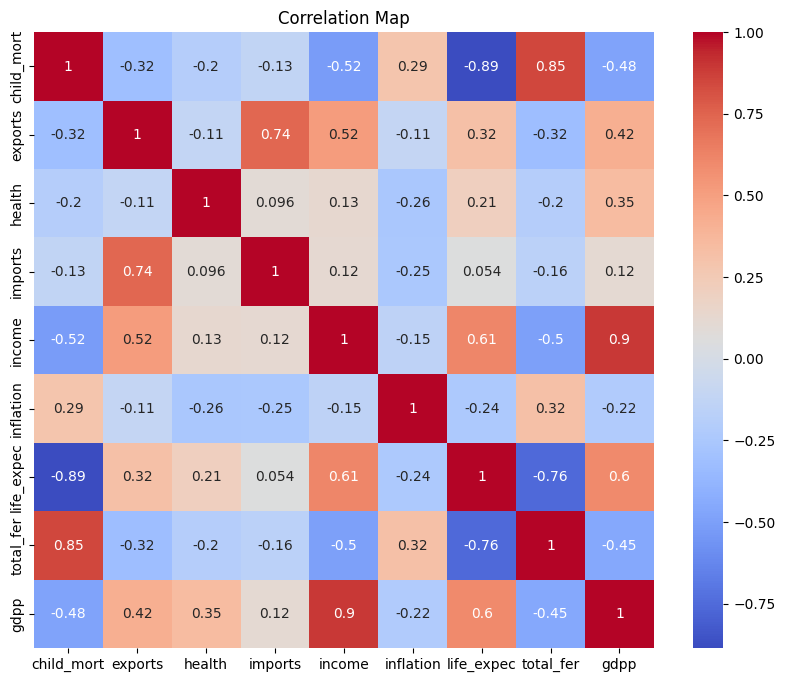

In [10]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap

# Calculate the correlation matrix
correlation = country_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Map")
plt.show()

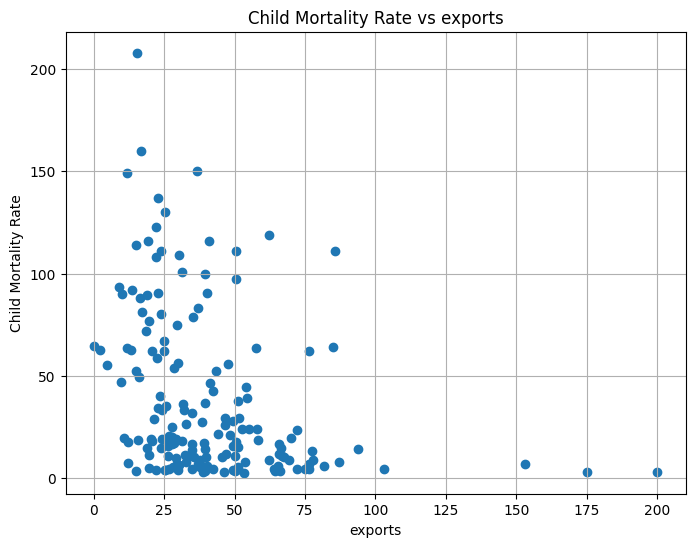

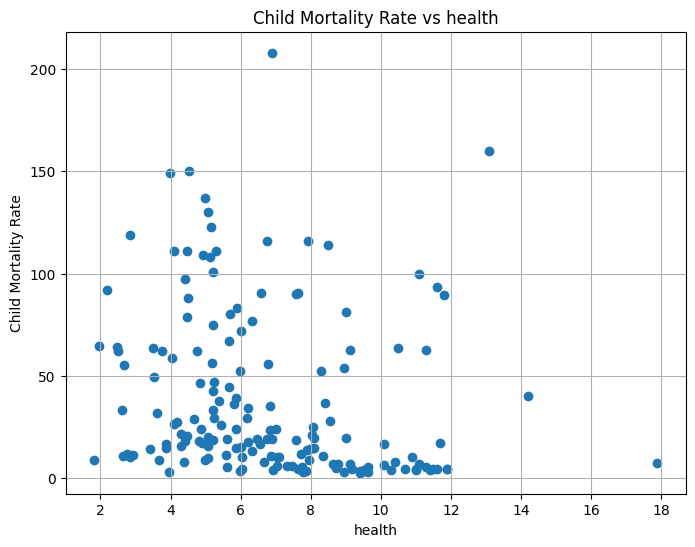

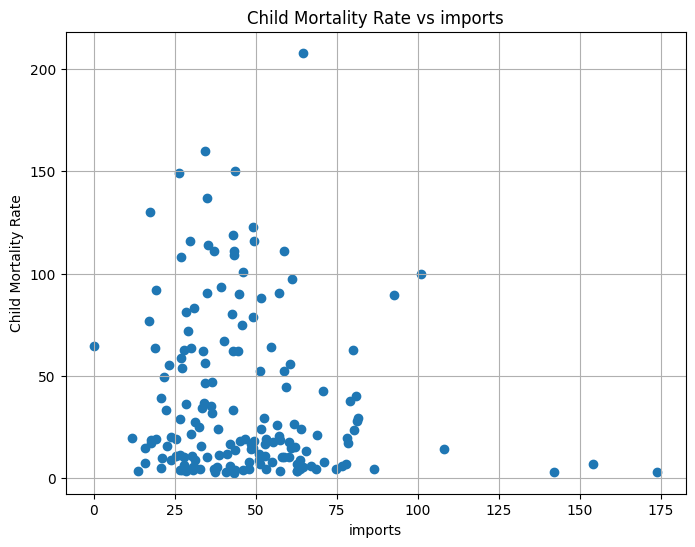

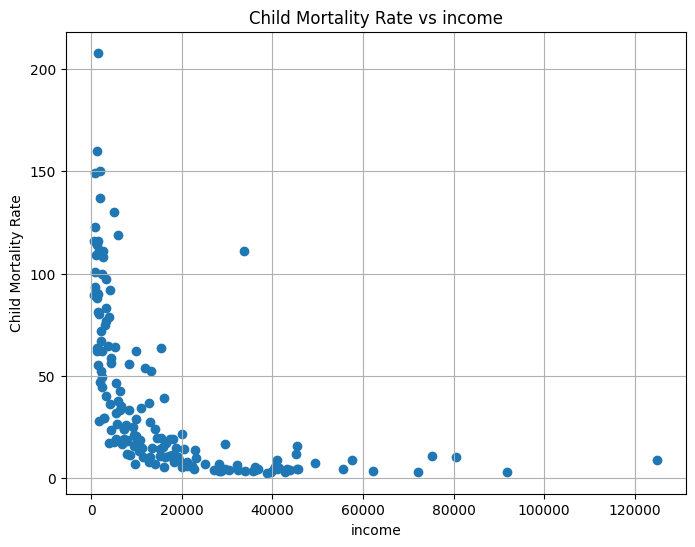

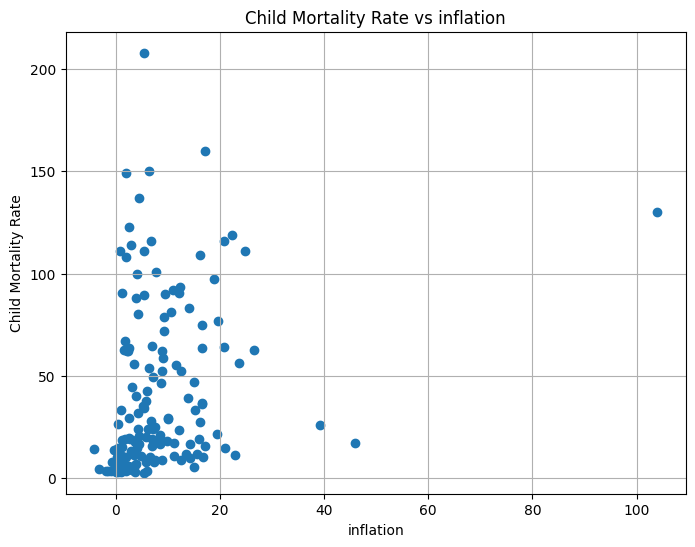

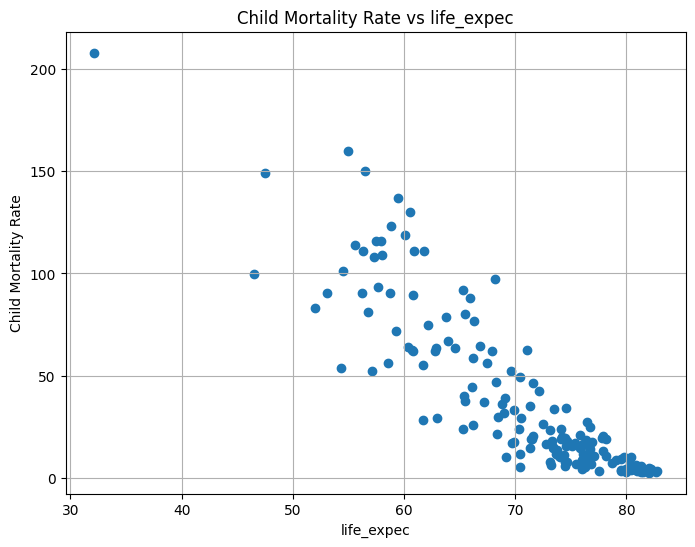

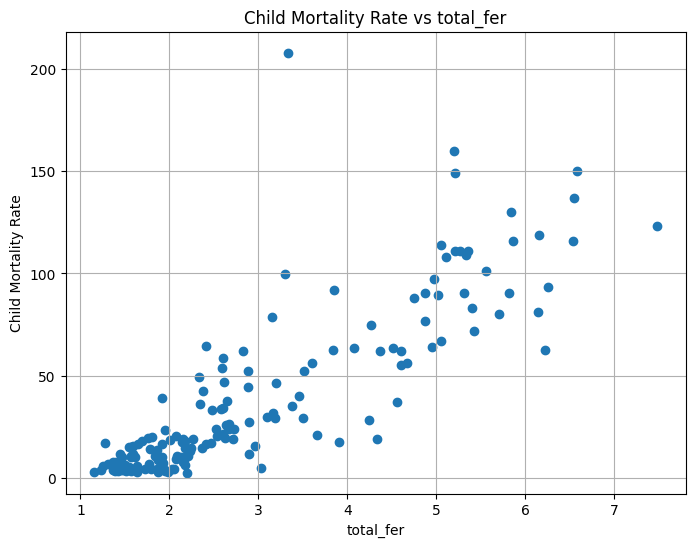

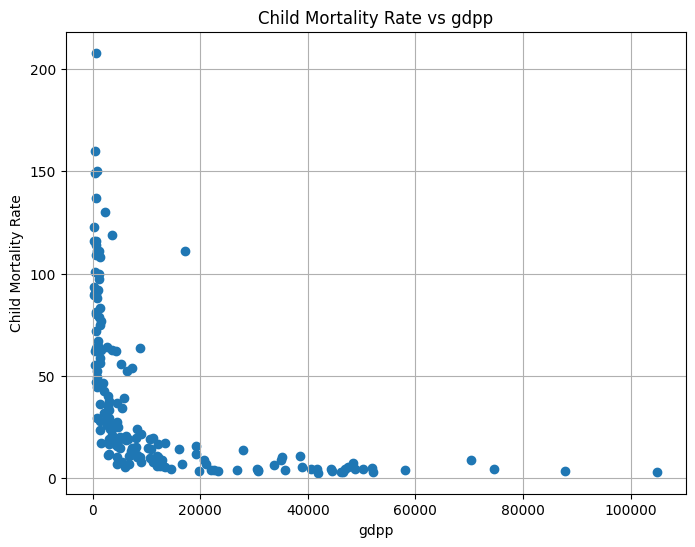

In [11]:
# Explore the continuous independent features against child_mort using scatter plots.
# Continuous features (excluding child_mortality)
continuous_features = ["exports", "health", "imports", "income", "inflation", "life_expec", "total_fer", "gdpp"]

# Create scatter plots for each continuous feature against child_mortality
for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(country_df[feature], country_df["child_mort"])
    plt.xlabel(feature)
    plt.ylabel("Child Mortality Rate")
    plt.title(f"Child Mortality Rate vs {feature}")
    plt.grid(True)
    plt.show()

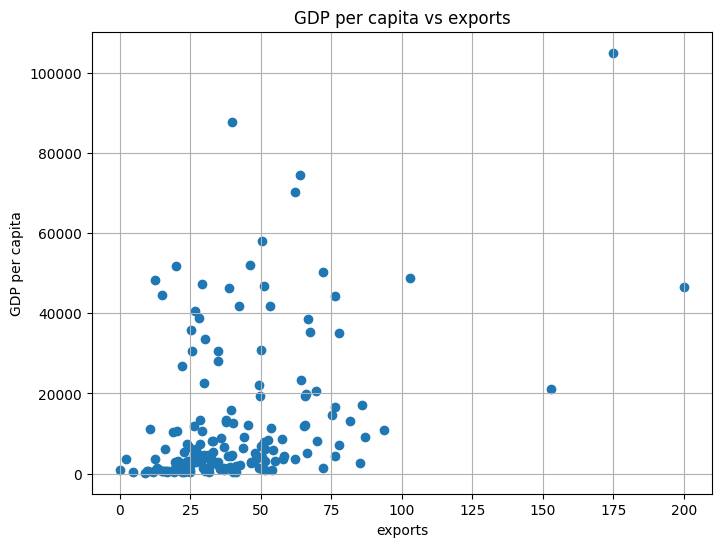

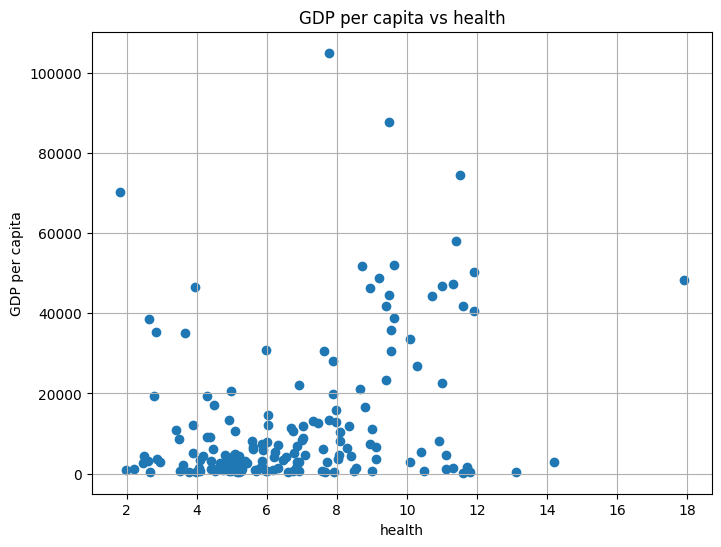

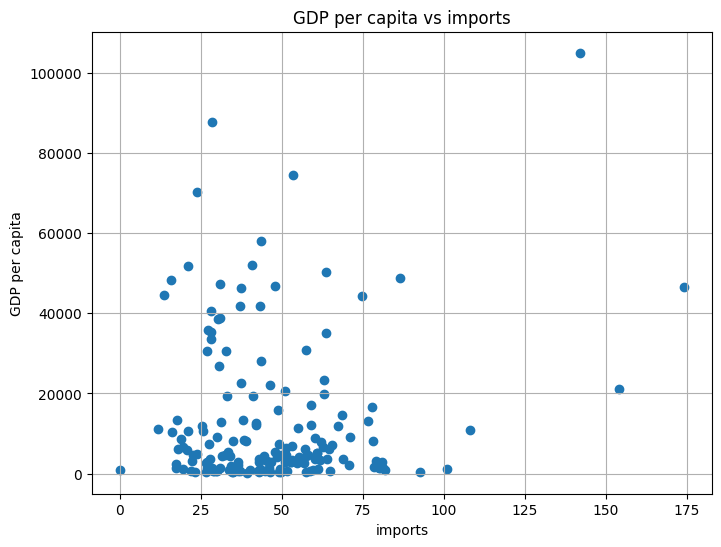

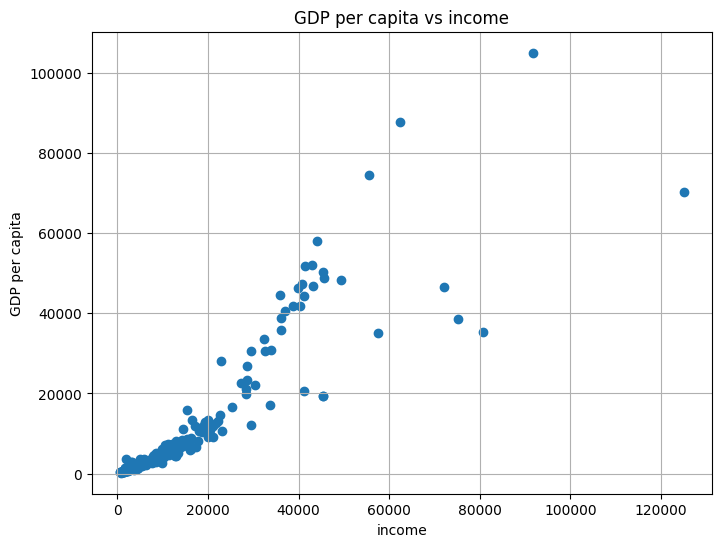

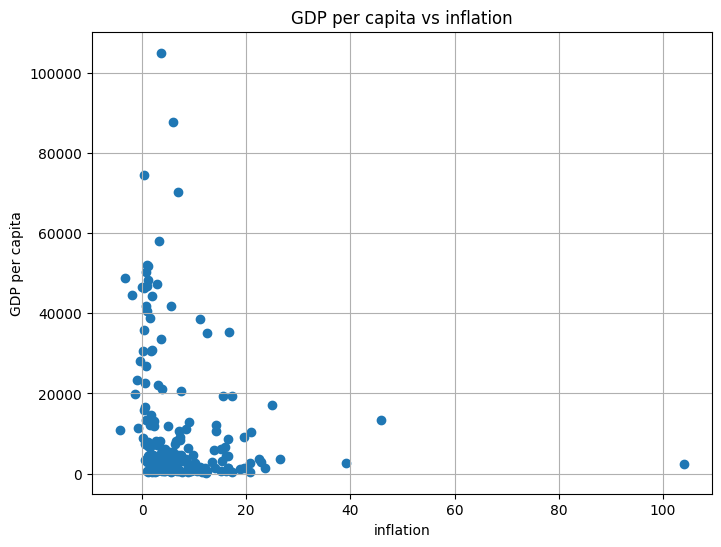

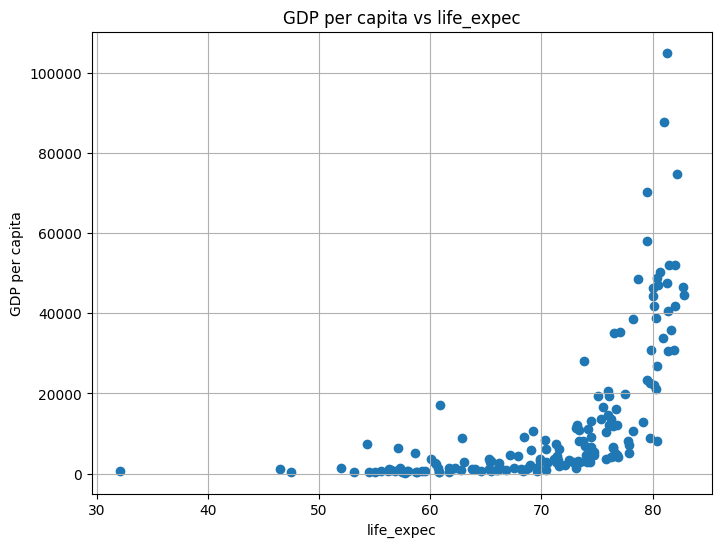

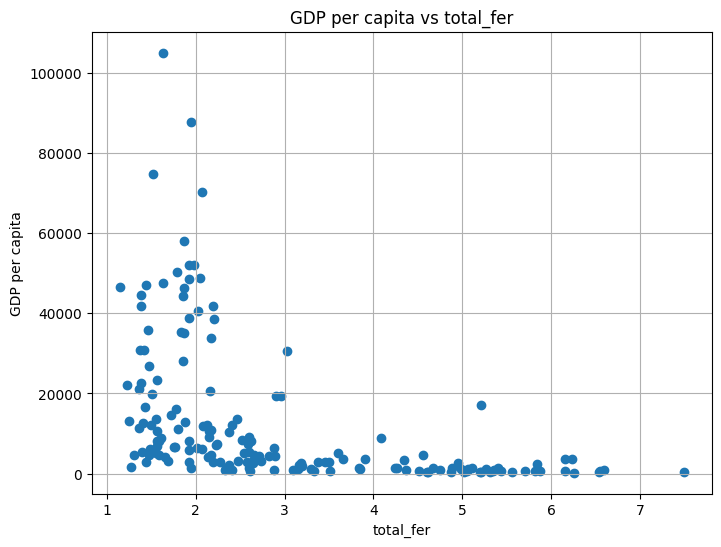

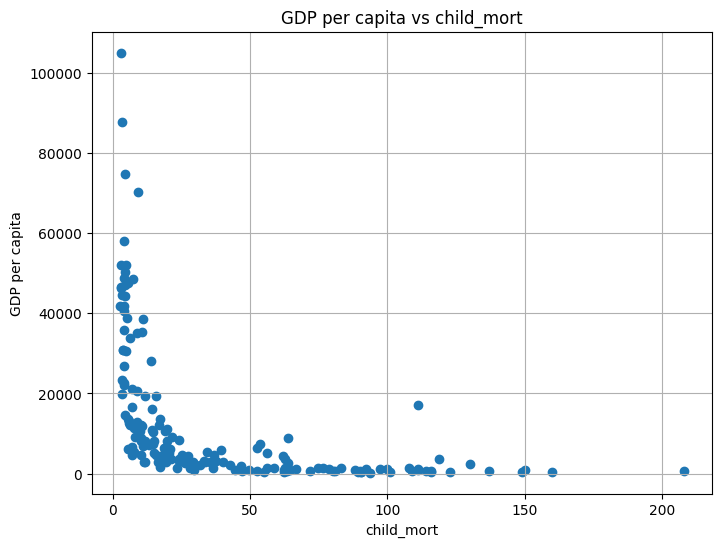

In [12]:
# Explore the continuous independent features against gdpp using scatter plots.

# Continuous features (excluding gdpp)
continuous_features = ["exports", "health", "imports", "income", "inflation", "life_expec", "total_fer", "child_mort"]

# Create scatter plots for each continuous feature against gdpp
for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(country_df[feature], country_df["gdpp"])
    plt.xlabel(feature)
    plt.ylabel("GDP per capita")
    plt.title(f"GDP per capita vs {feature}")
    plt.grid(True)
    plt.show()

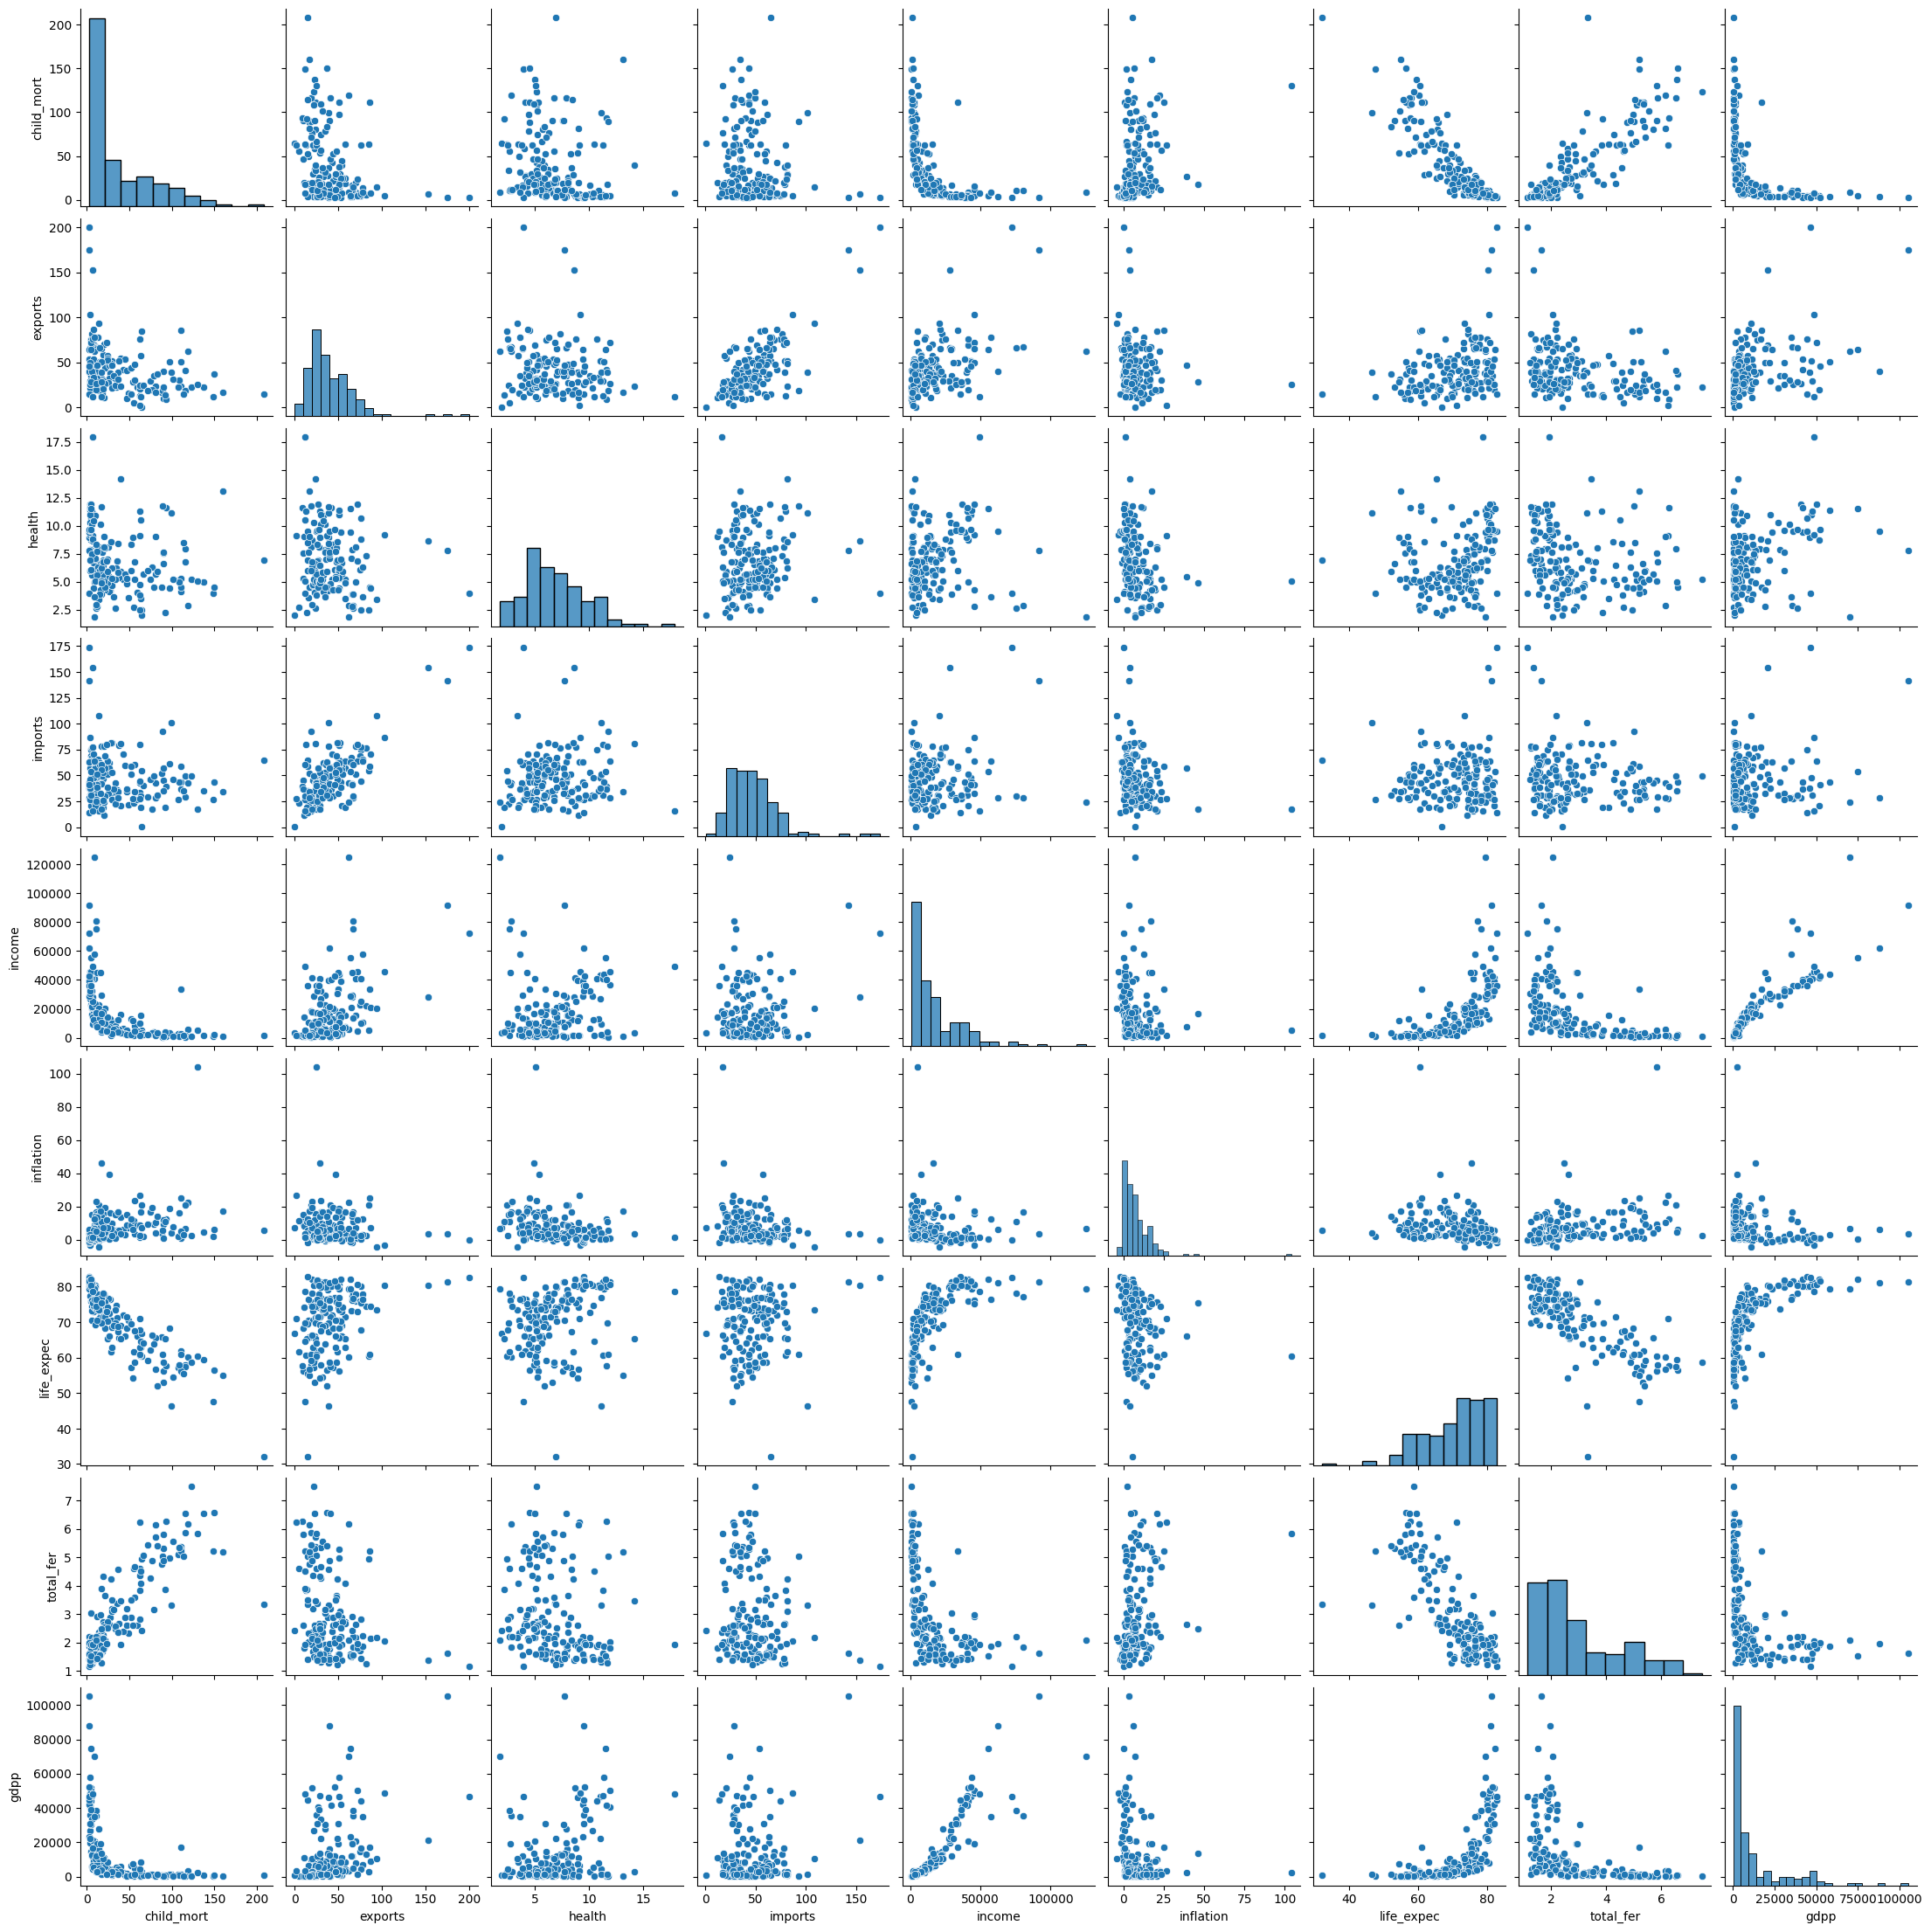

In [13]:
# Create a pair plot
# Hint: Explore seaborn pairplot

sns.pairplot(country_df)
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [14]:
# Normalise the data using MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the data
df_scaled = pd.DataFrame(scaler.fit_transform(country_df))

# Assign column names (optional, assuming same as original data)
df_scaled.columns = country_df.columns

# Print the first few rows of the normalized DataFrame
# print(df_scaled.head())

df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

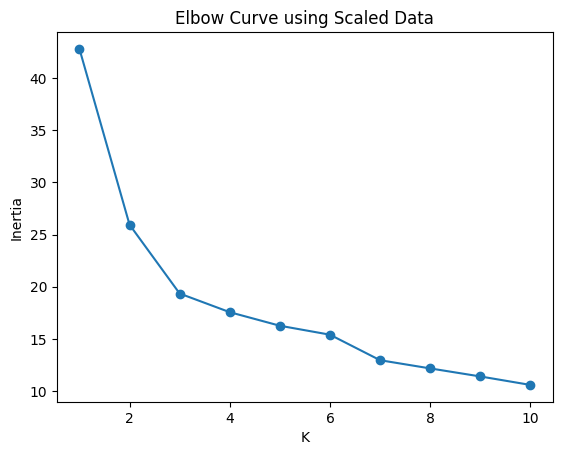

In [15]:
# # Plot elbow curve
# def eval_Kmeans(x, k, r):
#     kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
#     kmeans.fit(x)
#     return kmeans.inertia_

# def elbow_Kmeans(x, max_k=10, r=42):
#     within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
#     plt.plot(range(1, 11), within_cluster_vars,marker='o')
#     plt.xlabel('K')
#     plt.ylabel('Inertia')
#     plt.show()

#     # Plot elbow curve using scaled dataset
#     elbow_Kmeans(df_scaled)

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.cluster import KMeans

# Define function to evaluate KMeans
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

# Define function to plot elbow curve
def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars, marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.title('Elbow Curve using Scaled Data')
    plt.show()

# Plot elbow curve using scaled data
elbow_Kmeans(df_scaled)


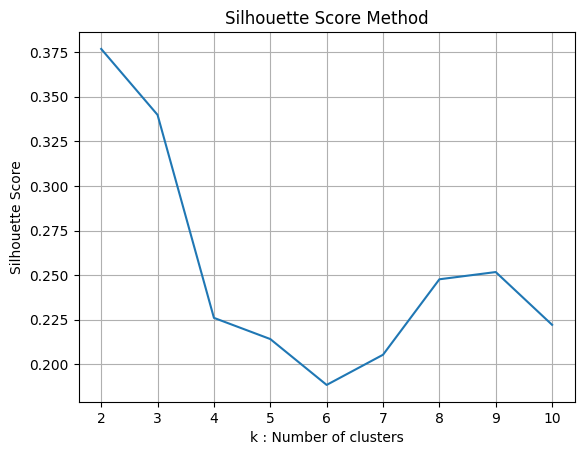

In [16]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the selected K value

In [17]:
# Remember to set the random_state to rseed
# Define the number of clusters (K)
k = 6

# Fit the K-Means model
kmeans = KMeans(n_clusters=k, random_state=rseed)
kmeans.fit(df_scaled)

# Predict cluster labels
labels = kmeans.labels_

In [18]:
# Count the number of records in each cluster
cluster_counts = pd.Series(labels).value_counts()  # Convert labels to Series
print("Cluster counts:")
print(cluster_counts)

Cluster counts:
5    44
1    37
3    28
4    26
0    26
2     6
Name: count, dtype: int64


In [19]:
# Check model performance with the silhouette coefficient
silhouette_coeff = silhouette_score(df_scaled, labels)
print("Silhouette coefficient:", silhouette_coeff)

Silhouette coefficient: 0.1885039549479893


## Predictions

In [20]:
# Add the predicted cluster label column to the original dataframe
country_df['cluster_label'] = labels

# Print the first few rows of the modified DataFrame
print(country_df.head())

                     child_mort  exports  health  imports  income  inflation  \
country                                                                        
Afghanistan                90.2     10.0    7.58     44.9    1610       9.44   
Albania                    16.6     28.0    6.55     48.6    9930       4.49   
Algeria                    27.3     38.4    4.17     31.4   12900      16.10   
Angola                    119.0     62.3    2.85     42.9    5900      22.40   
Antigua and Barbuda        10.3     45.5    6.03     58.9   19100       1.44   

                     life_expec  total_fer   gdpp  cluster_label  
country                                                           
Afghanistan                56.2       5.82    553              4  
Albania                    76.3       1.65   4090              5  
Algeria                    76.5       2.89   4460              5  
Angola                     60.1       6.16   3530              4  
Antigua and Barbuda        76.8      

## Visualisation of clusters

In [21]:
# Visualisation of clusters: child mortality vs gdpp


In [22]:
# Visualisation of clusters: inflation vs gdpp


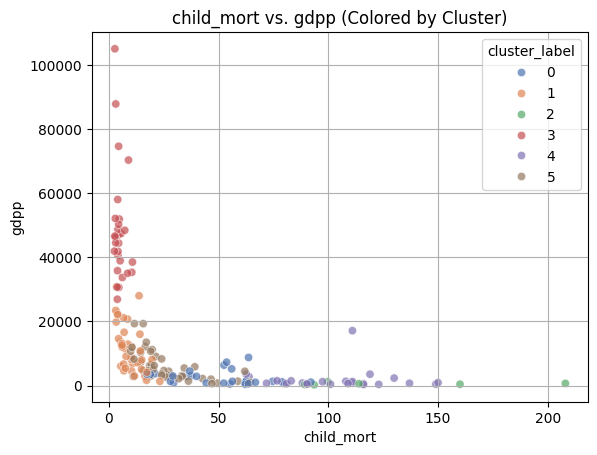

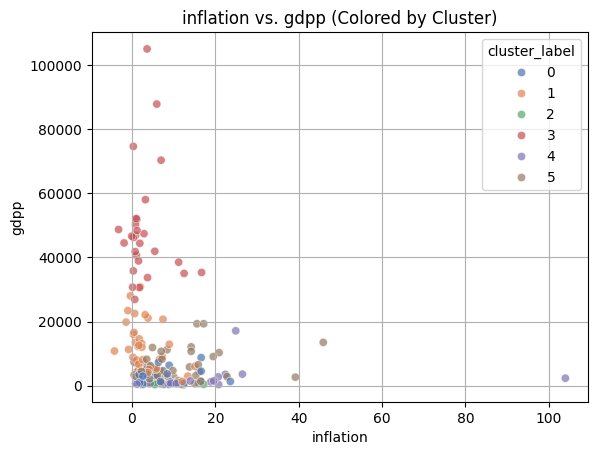

In [23]:
def visualize_clusters(feature1, feature2):
    sns.scatterplot(
        x=feature1,
        y=feature2,
        hue='cluster_label',
        palette='deep',
        data=country_df,
        alpha=0.7
    )
    plt.title(f'{feature1} vs. {feature2} (Colored by Cluster)')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.grid(True)
    plt.show()

# Visualize clusters
visualize_clusters('child_mort', 'gdpp')
visualize_clusters('inflation', 'gdpp')

In [24]:
country_df.head()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,4
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,5
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,5
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,4
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1


## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**